# Tasks
This notebook is for conducting an analysis, no finite plots will be constructed here.


* Insulation score analysis
    * Get insulations scores (IS)
    * Do ANOVA (or t-test) for IS
    * Conduct functional analysis GSEA (MSIGDB, KEGG, REACTOME, GO:BP)

# Uploads

In [1]:
# If you are a developer, you may want to reload the packages on a fly. 
# Jupyter has a magic for this particular purpose:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import cooler
import pyranges as pr
from statsmodels.stats.multitest import multipletests as fdr_correction
from sklearn.feature_selection import f_classif
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
 
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns

from glob import glob
from os.path import basename, splitext
from importlib import reload
import gffpandas.gffpandas as gffpd
from natsort import natsorted

import utils
from utils.anova import *
from utils.gene_intervals import bins_to_genes_intersection
from utils.plot_functions import *
from utils.hic_preproc import *
reload(utils.anova)
reload(utils.plot_functions)
reload(utils.hic_preproc)

<module 'utils.hic_preproc' from '/home/dkriukov/mice/Aging_Brain_Mice/utils/hic_preproc.py'>

In [2]:
#crucial work dirs
COOLER_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC'
DOWNSAMPLED_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/downsampled'
INSULATION_PATH = '/tank/projects/kriukov_chromatin/HIC/insulation'
COMPARTMENTS_PATH = '/tank/projects/kriukov_chromatin/HIC/compartments'
GENOME_FOLDER_PATH = '/tank/projects/kriukov_chromatin/GENOME'
ATAC_FOLDER_PATH = '/tank/projects/kriukov_chromatin/ATAC'

In [3]:
#import genes
gffpath = '%s/GCF_000001635.27_GRCm39_genomic.gff' % GENOME_FOLDER_PATH
annot_path = '%s/GCF_000001635.27_GRCm39_assembly_report.txt' % GENOME_FOLDER_PATH
#refseq to chrom annotation
annotation = gffpd.read_gff3(gffpath)
fasta_annot = pd.read_csv(annot_path, sep='\t', skiprows=28)
refseq2chrom = dict(zip(fasta_annot['RefSeq-Accn'].values, fasta_annot['UCSC-style-name'].values))
gn = annotation.attributes_to_columns()
gn.seq_id = gn.seq_id.map(refseq2chrom)
gn['length'] = gn['end'] - gn['start']
gn = gn[['seq_id', 'source', 'type', 'start', 'end', 'score', 'strand',
         'ID', 'Name', 'description', 'length', 'chromosome']]

#types of sequences
gn_code = gn[gn['type']=='gene'] #protein codeing
gn_lnc = gn[gn['type']=='lnc_RNA'] #long non-coding
gn_trna = gn[gn['type']=='tRNA'] #tRNA
gn_rrna = gn[gn['type']=='rRNA'] #rRNA

In [5]:
!ls /tank/projects/kriukov_chromatin/HIC/insulation

IS_50000.csv


In [3]:
RESOLUTION = 50000
FILES = natsorted(glob('%s/*.mcool' % COOLER_FOLDER_PATH))
#FILES = natsorted(glob('%s/*%s.cool' % (DOWNSAMPLED_FOLDER_PATH, RESOLUTION)))
CLRS = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in FILES]

#insulation score
IS = pd.read_csv('%s/IS_50000.csv' % INSULATION_PATH, index_col=0)

#consensus peaks
ATAC = pd.read_csv('%s/consensus_peaks.mLb.clN.boolean.annotatePeaks.txt' % ATAC_FOLDER_PATH, sep='\t')

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Insulation score analysis

## TAD shift analysis

In [4]:
from scipy.signal import argrelextrema
import scipy.optimize as optimization

explore = ['WT', 'young', 'old', 'KO']
mask = np.array([any([e in c for e in explore]) for c in IS.columns])

X = IS.drop(IS.columns[~mask], 1).T
#X = X.dropna(axis=1)

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


In [5]:
order = 5
indices = []
for i in range(X.shape[0]):
    row = X.iloc[i,:]
    s = np.array(row)
    lm = argrelextrema(s, np.less, order=order)[0]
    indices.append(row.iloc[lm].index)

result = sorted(list(set(indices[0]).intersection(*indices)))
border_dict = dict(zip(list(X.index), indices))

In [6]:
convex_dict = {}
for key in border_dict.keys():
    b = border_dict[key]
    convex_dict[key] = {}
    for i in range(b.shape[0]):
        x = np.arange(-order, order+1)
        v = X.loc[key, b[i]-order:b[i]+order] #vicinity of minimum
        y = v.to_numpy()

        def func(x, a):
            return a*(x**2) + y[y.shape[0]//2]

        params, _ = optimization.curve_fit(func, x, y)
        convex_dict[key][b[i]] = params.item()
    

# plt.scatter(x, y, marker='o', c='red')
# plt.plot(x, func(x, params), c='black')
# plt.show()

37449

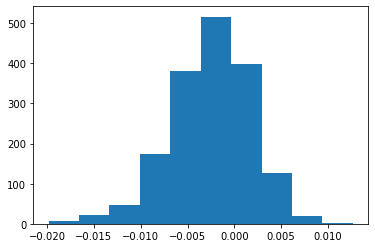

In [7]:
test = border_dict['KO_male_1'].intersection(border_dict['young_male_1']).tolist()


diff = []
for t in test:
    d = convex_dict['KO_male_1'][t] - convex_dict['young_male_1'][t]
    diff.append(d)

plt.hist(diff)
test[np.argmin(diff)]

In [54]:
pos = 105
st, fin = (pos-100, pos+100) # in bins

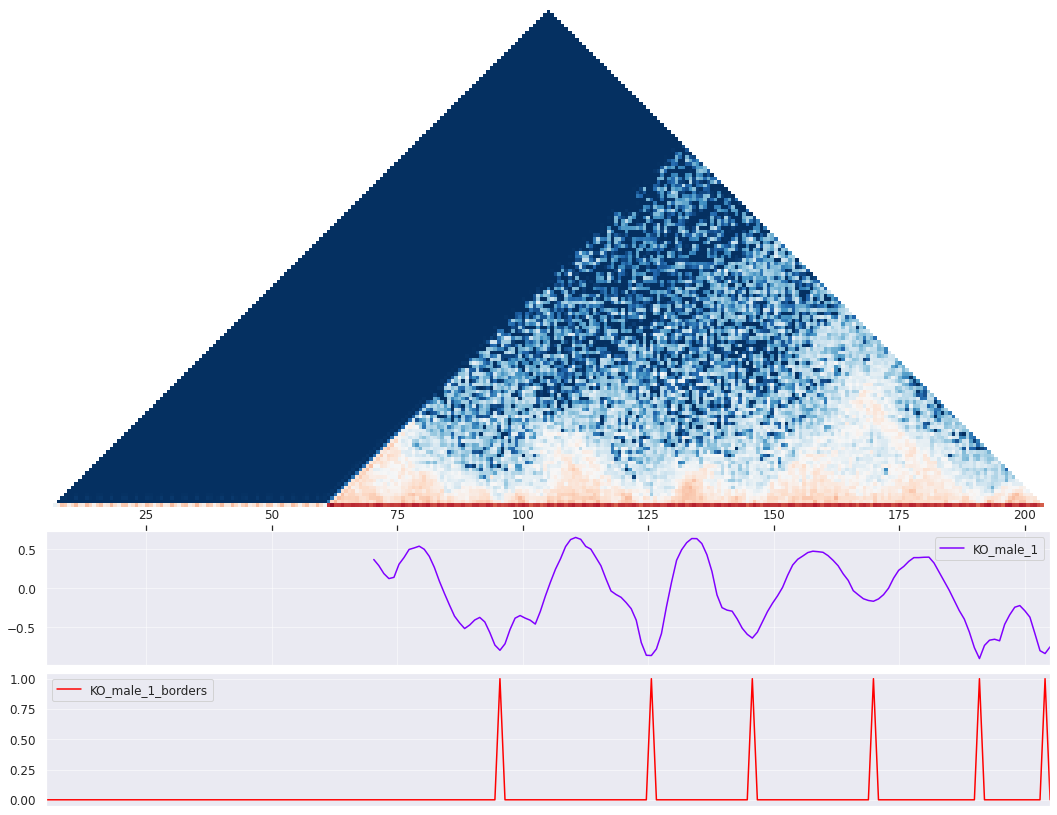

In [55]:
rep = 'KO_male_1'

assert len(IS.loc[st:fin].chrom.unique()) == 1, 'choose one chromosome interval'
chrom = IS.loc[st:fin].chrom.unique()[0]

#HI-C
cool = [c for c in CLRS if c.filename.__contains__(rep)][0]
D = cool.matrix(balance=True).fetch(chrom)
D = mylog(D, log=True)
bins = cool.bins()[:]
start = bins[bins.chrom==chrom].index[0]
#IS
profile = np.array(IS[rep])#.loc[st:fin-1])
#TAD BORDERS
borders_plot = np.zeros(profile.shape)
for idx in border_dict[rep]:
    borders_plot[idx] += 1

plot_hic(D, st, fin, profile=[profile, borders_plot], 
                         profnames=[rep, rep + '_borders'], chrom_start=start)

In [15]:
# rep = 'young_male_1'

# assert len(IS.loc[st:fin].chrom.unique()) == 1, 'choose one chromosome interval'
# chrom = IS.loc[st:fin].chrom.unique()[0]

# #HI-C
# cool = [c for c in CLRS if c.filename.__contains__(rep)][0]
# D = cool.matrix(balance=True).fetch(chrom)
# D = mylog(D, log=True)
# bins = cool.bins()[:]
# start = bins[bins.chrom==chrom].index[0]
# #IS
# profile = np.array(IS[rep])#.loc[st:fin-1])
# #TAD BORDERS
# borders_plot = np.zeros(profile.shape)
# for idx in border_dict[rep]:
#     borders_plot[idx] += 1

# plot_hic(D, st, fin, profile=[profile, borders_plot], 
#                          profnames=[rep, rep + '_borders'], chrom_start=start)

In [16]:
#coolpuppy API
# import libraries for biological data analysis
from coolpuppy import coolpup
from plotpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis
from cooltools.lib import plotting
import logging
logging.getLogger().disabled = True
sns.set_theme(font_scale=2)

# Use bioframe to fetch the genomic features from the UCSC.
mm10_chromsizes = bioframe.fetch_chromsizes('mm10')
mm10_cens = bioframe.fetch_centromeres('mm10')
mm10_arms = bioframe.make_chromarms(mm10_chromsizes, mm10_cens)

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
mm10_arms = mm10_arms.set_index("chrom").loc[CLRS[0].chromnames].reset_index()
# call this to automaticly assign names to chromosomal arms:
mm10_arms = bioframe.make_viewframe(mm10_arms)

## interTADs

In [17]:
#construct average interTADs
pup = pd.DataFrame()
cond = [basename(c.filename).split('_')[0] for c in CLRS]
for k, v in border_dict.items():
    clr = [c for c in CLRS if c.filename.__contains__(k)][0]
    name = splitext(basename(clr.filename))[0]
    sites = IS.loc[v.tolist(),['chrom', 'start', 'end']].reset_index(drop=True)
    # Calculate expected interactions for chromosome arms
    expected = expected_cis(clr, view_df=mm10_arms, chunksize=1000000, nproc=18)
    #calculate mean interTADs
    cc = coolpup.CoordCreator(sites, resolution=RESOLUTION, 
                              features_format='bed', local=True, flank=1_000_000)
    pu = coolpup.PileUpper(clr, cc, expected=expected, view_df=mm10_arms, ignore_diags=0)
    pup = pup.append(pu.pileupsWithControl(nproc=18))
pup['condition'] = cond
pup['id'] = [basename(c.filename).split('_')[1] + '_' + basename(c.filename).split('_')[2].split('.')[0] for c in CLRS]

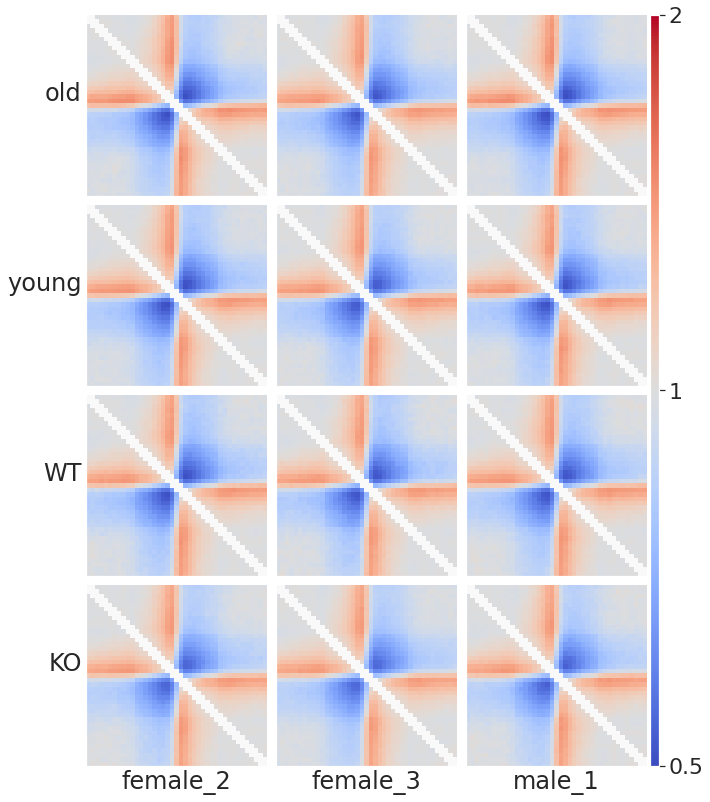

In [18]:
plotpup.make_heatmap_grid(pup,
                          rows='condition', #col_order=['--', '++'],
                          cols='id',
                          score=False, cmap='coolwarm', scale='log',
                          sym=True, vmax=2,
                          height=3)

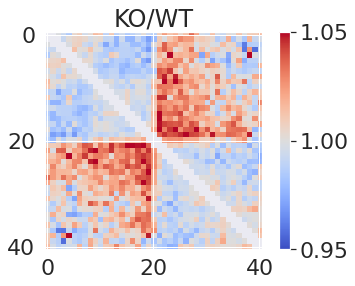

In [19]:
divv = pup[pup.condition=='KO']['data'][2] / pup[pup.condition=='WT']['data'][2]
plt.imshow(divv, interpolation='None', cmap='coolwarm', vmax=1.05, vmin=0.95)
plt.title('KO/WT')
plt.colorbar()

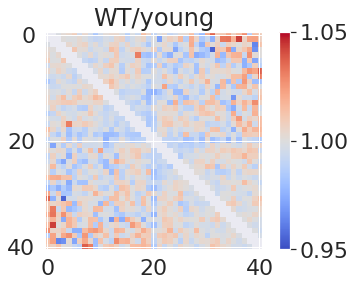

In [20]:
divv = pup[pup.condition=='WT']['data'][0] / pup[pup.condition=='young']['data'][0]
plt.imshow(divv, interpolation='None', cmap='coolwarm', vmax=1.05, vmin=0.95)
plt.title('WT/young')
plt.colorbar()

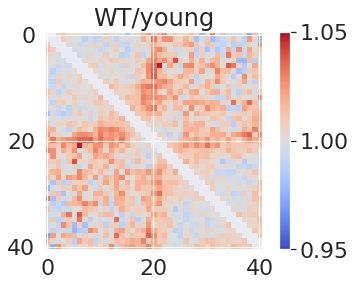

In [21]:
divv = pup[pup.condition=='old']['data'][0] / pup[pup.condition=='young']['data'][0]
plt.imshow(divv, interpolation='None', cmap='coolwarm', vmax=1.05, vmin=0.95)
plt.title('WT/young')
plt.colorbar()

## TADs

In [61]:
#construct average TADs
pup = pd.DataFrame()
cond = [basename(c.filename).split('_')[0] for c in CLRS]
for k, v in border_dict.items():
    clr = [c for c in CLRS if c.filename.__contains__(k)][0]
    name = splitext(basename(clr.filename))[0]
    #assumption: TADs are not intermittent
    sites = IS.loc[v.tolist(),['chrom', 'start', 'end']].reset_index(drop=True)
    sites['end'] = np.roll(sites['end'], -1)
    sites = sites[:-1]
    
    sites = sites.head(1)
    # Calculate expected interactions for chromosome arms
    expected = expected_cis(clr, view_df=mm10_arms, chunksize=1000000, nproc=18)
    #calculate mean interTADs
    cc = coolpup.CoordCreator(sites, resolution=RESOLUTION, 
                              features_format='bed', local=True, flank=1_000_000)
    pu = coolpup.PileUpper(clr, cc, 
                           #expected=expected, 
                           rescale=True,
                           view_df=mm10_arms, ignore_diags=0)
    pup = pup.append(pu.pileupsWithControl(nproc=18))
pup['condition'] = cond
pup['id'] = [basename(c.filename).split('_')[1] + '_' + basename(c.filename).split('_')[2].split('.')[0] for c in CLRS]

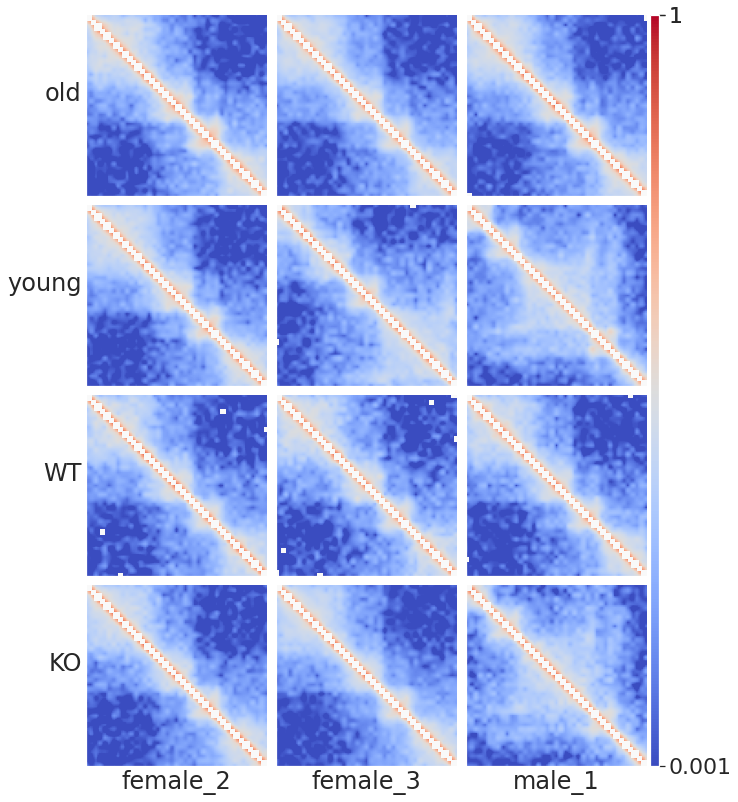

In [100]:
plotpup.make_heatmap_grid(pup,
                          rows='condition', #col_order=['--', '++'],
                          cols='id',
                          score=False, cmap='coolwarm', scale='log',
                          sym=True, vmax=1., vmin=0.001,
                          height=3)

## ANOVA analysis

In [61]:
explore = ['WT', 'young', 'old']
mask = np.array([any([e in c for e in explore]) for c in IS.columns])

X = IS.drop(IS.columns[~mask], 1).T
X = X.dropna(axis=1)

y = [d.split('_')[0] for d in X.index] #0-for age; 1-for sex

types_dict = {'WT':'Y', 'young':'Y', 'old':'old', 'KO':'KO'}
y = [types_dict[t] for t in y]
print(y)

['Y', 'Y', 'Y', 'old', 'old', 'old', 'Y', 'Y', 'Y']


/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


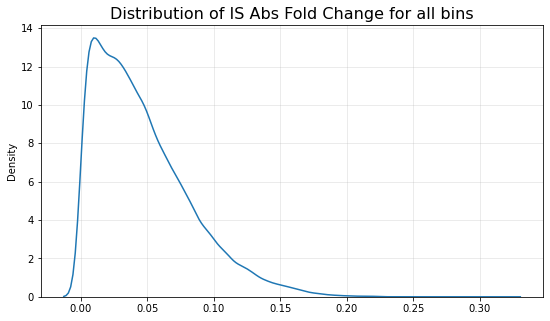

Total number of features: 42953
Number of p_values <= 0.050: 11162
Number of p_values after FDR correction: 4


,14282,14283,14284,35648
WT_female_2,0.444180,0.413791,0.379288,-0.265062
WT_female_3,0.434824,0.409935,0.391529,-0.276402
WT_male_1,0.431056,0.433262,0.423213,-0.249603
old_female_2,0.528548,0.539883,0.520195,-0.067546
old_female_3,0.516813,0.534430,0.513157,-0.106329
old_male_1,0.532389,0.524549,0.528388,-0.079973
young_female_2,0.429855,0.425943,0.393686,-0.286080
young_female_3,0.435138,0.423855,0.405221,-0.250814
young_male_1,0.414353,0.417796,0.401963,-0.292838


In [62]:
anova = ANOVA(X, y, 0.05)
anova.get_filter_distribution('FC')

a, b = anova.make_anova()
anova.get_passed_features()

100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


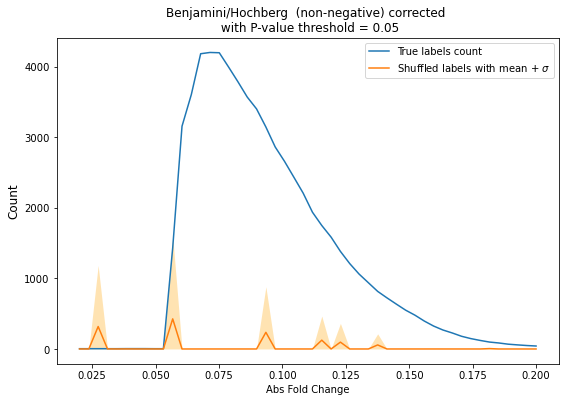

0.07142857142857144

In [63]:
anova.make_permutation_search('FC', interval=(0.02, 0.2), steps=50, N=15, **{'ddof':1})
anova.plot_permutation_results()
anova.get_best_criterion()

In [74]:
X_s, FDR, Pval = anova.get_passed_features_for_some_criterion(criterion=anova.get_best_criterion(), 
                                                        return_pvals=True)
P_adj_s_sorted = np.sort(FDR[1][FDR[0]])
X_s_sorted = X_s.iloc[:, np.argsort(FDR[1][FDR[0]])]

order = ['old', 'Y']
X_group = X_s_sorted.groupby(y).mean()
X_diff = X_group.loc[order[0]] - X_group.loc[order[1]]
#extract intervals and p_values, take top N bins
X_passed_intervals = IS.loc[X_s_sorted.columns][['chrom', 'start', 'end']]
X_passed_intervals['pval'] = Pval[FDR[0]]
X_passed_intervals['p_adj'] = P_adj_s_sorted
X_passed_intervals['FC'] = X_diff

print("Bins passed: %d" % X_passed_intervals.shape[0])

Bins passed: 4202


In [138]:
top = max(500, X_passed_intervals.shape[0])
X_top = X_passed_intervals.sort_values('pval').iloc[:top, :]

#intersection with genes
significant_genes = bins_to_genes_intersection(X_top[['chrom', 'start', 'end']], gn_code)

In [139]:
genesFC = significant_genes.merge(X_top, 
                    left_on=['Chromosome', 'Start_b', 'End_b'], 
                    right_on=['chrom', 'start', 'end'])[['chrom', 'Start', 'End', 'Start_b', 'End_b', 'Name', 'pval', 'FC']]

gmean = lambda x: np.exp(np.mean(np.log(x)))
agg = genesFC.groupby(['Name']).agg({'Start':'first','End':'first', 
                                     'Start_b':'first', 'End_b':'last', 
                                     'pval':gmean, 'FC':'mean'})
agg['p_adj'] = fdr_correction(agg['pval'], alpha=0.05, method='fdr_bh')[1]
agg['ES'] = -np.log10(agg['pval']) * agg['FC']

In [143]:
agg.to_csv('subdata/IS_results.csv')

In [136]:
#Assumptions:
# - Equal variances (sample sizes)
# - Normal distribution of population
# - Independence
EXPLORES = [['old', 'young'], ['KO', 'young'], ['WT', 'young'], ['KO', 'WT'], ['old', 'WT']]
gmean = lambda x: np.exp(np.mean(np.log(x)))

for explore in tqdm(EXPLORES):
    ### Data filtering
    fname = '::'.join(explore)
    mask = np.array([any([e in c for e in explore]) for c in IS.columns])
    X = IS.drop(IS.columns[~mask], 1).T
    X = X.dropna(axis=1)
    y = [d.split('_')[0] for d in X.index] #0-for age; 1-for sex
    
    ### ANOVA
    anova = ANOVA(X, y, 0.02)
    p, pcor = anova.make_anova()
    X_group = X.groupby(y).mean()
    X_diff = X_group.loc[explore[0]] - X_group.loc[explore[1]]
    #extract intervals and p_values, take top N bins
    X_passed_intervals = IS.loc[X.columns][['chrom', 'start', 'end']]
    X_passed_intervals['pval'] = p
    X_passed_intervals['FC'] = X_diff
   
    # #anova.make_permutation_search('FC', interval=(0.02, 0.2), steps=50, N=15, **{'ddof':1})
    # X_s, P_s = anova.get_passed_features_for_some_criterion(criterion=anova.get_best_criterion(), 
    #                                                         return_pvals=True)
    # #plot
    # #anova.plot_permutation_results(savename='Insulation/' + fname + '_FC.png')
    
    # P_adj_s_sorted = np.sort(P_s[1][P_s[0]])
    # X_s_sorted = X_s.iloc[:, np.argsort(P_s[1][P_s[0]])]
    
    #extract intervals and p_values, take top N bins
    # X_passed_intervals = IS_info.loc[X_s_sorted.columns][['chrom', 'start', 'end']]
    # X_passed_intervals['p_adj'] = P_adj_s_sorted
    # X_top = X_passed_intervals.iloc[:top, :]
    
    # #intersection with genes
    significant_genes = bins_to_genes_intersection(X_passed_intervals[['chrom', 'start', 'end']], gn_code)
    genesFC = significant_genes.merge(X_passed_intervals, 
                    left_on=['Chromosome', 'Start_b', 'End_b'], 
                    right_on=['chrom', 'start', 'end'])[['chrom', 'Start', 'End', 'Start_b', 'End_b', 'Name', 'pval', 'FC']]

    agg = genesFC.groupby(['Name']).agg({'Start':'first','End':'first', 
                                        'Start_b':'first', 'End_b':'last', 
                                        'pval':gmean, 'FC':'mean'})
    agg['p_adj'] = fdr_correction(agg['pval'], alpha=0.05, method='fdr_bh')[1]
    agg['ES'] = -np.log10(agg['pval']) * agg['FC'] * (-1) # corresponds to "openness"
    #break
    # print('Found %d genes in top %d bins' % (len(significant_genes), top))
    agg.to_csv('subdata/IS_results_%s.csv' % (fname))

  0%|          | 0/5 [00:00<?, ?it/s]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.020: 1917
Number of p_values after FDR correction: 0


 20%|██        | 1/5 [00:04<00:19,  4.94s/it]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.020: 7735
Number of p_values after FDR correction: 1


 40%|████      | 2/5 [00:09<00:14,  4.85s/it]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.020: 927
Number of p_values after FDR correction: 0


 60%|██████    | 3/5 [00:14<00:09,  4.87s/it]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.020: 10050
Number of p_values after FDR correction: 0


 80%|████████  | 4/5 [00:19<00:04,  4.84s/it]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.020: 3842
Number of p_values after FDR correction: 1


100%|██████████| 5/5 [00:24<00:00,  4.82s/it]


In [137]:
ko = pd.read_csv('subdata/IS_results_KO::young.csv', index_col=0)
wt = pd.read_csv('subdata/IS_results_WT::young.csv', index_col=0)
old = pd.read_csv('subdata/IS_results_old::young.csv', index_col=0)
kow = pd.read_csv('subdata/IS_results_KO::WT.csv', index_col=0)
oldw = pd.read_csv('subdata/IS_results_old::WT.csv', index_col=0)

In [138]:
ES = pd.DataFrame()
ES['KO'] = ko['ES']
ES['WT'] = wt['ES']
ES['old'] = old['ES']
ES['KO-W'] = kow['ES']
ES['old-W'] = oldw['ES']

ES.corr()

,KO,WT,old,KO-W,old-W
KO,1.000000,-0.045825,0.357672,0.803011,0.282115
WT,-0.045825,1.000000,-0.056689,-0.477473,-0.649553
old,0.357672,-0.056689,1.000000,0.329940,0.674201
KO-W,0.803011,-0.477473,0.329940,1.000000,0.599089
old-W,0.282115,-0.649553,0.674201,0.599089,1.000000


# ATAC-seq peaks

In [18]:
ATAC.columns[60:60]

Index(['KO_R1.mLb.clN.qval', 'KO_R2.mLb.clN.qval', 'KO_R3.mLb.clN.qval',
       'WT_R1.mLb.clN.qval', 'WT_R2.mLb.clN.qval', 'WT_R3.mLb.clN.qval',
       'old_R1.mLb.clN.qval', 'old_R2.mLb.clN.qval', 'old_R3.mLb.clN.qval',
       'young_R1.mLb.clN.qval', 'young_R2.mLb.clN.qval',
       'young_R3.mLb.clN.qval', 'KO_R1.mLb.clN.pval', 'KO_R2.mLb.clN.pval',
       'KO_R3.mLb.clN.pval', 'WT_R1.mLb.clN.pval', 'WT_R2.mLb.clN.pval',
       'WT_R3.mLb.clN.pval', 'old_R1.mLb.clN.pval', 'old_R2.mLb.clN.pval',
       'old_R3.mLb.clN.pval', 'young_R1.mLb.clN.pval', 'young_R2.mLb.clN.pval',
       'young_R3.mLb.clN.pval', 'KO_R1.mLb.clN.start', 'KO_R2.mLb.clN.start',
       'KO_R3.mLb.clN.start', 'WT_R1.mLb.clN.start', 'WT_R2.mLb.clN.start',
       'WT_R3.mLb.clN.start'],
      dtype='object')

In [25]:
peaks = ATAC[['chr', 'start', 'end', 'num_peaks', 'num_samples',
            'KO_R1.mLb.clN.bool', 'KO_R2.mLb.clN.bool', 'KO_R3.mLb.clN.bool',
            'WT_R1.mLb.clN.bool', 'WT_R2.mLb.clN.bool', 'WT_R3.mLb.clN.bool',
            'old_R1.mLb.clN.bool', 'old_R2.mLb.clN.bool', 'old_R3.mLb.clN.bool',
            'young_R1.mLb.clN.bool', 'young_R2.mLb.clN.bool', 'young_R3.mLb.clN.bool',
            'Distance to TSS','Gene Name']].copy()

In [27]:
peaks['length'] = ATAC['end'] - ATAC['start']
peaks['absTSS'] = np.abs(peaks['Distance to TSS'])

In [31]:
sum(peaks['absTSS'] < 500)

8383

In [19]:
ATAC[['chr', 'start', 'end', 'num_peaks', 'num_samples',
       'KO_R1.mLb.clN.fc', 'KO_R1.mLb.clN.pval', 'KO_R1.mLb.clN.qval', 'KO_R1.mLb.clN.start']]

,chr,start,end,num_peaks,num_samples,KO_R1.mLb.clN.fc,KO_R1.mLb.clN.pval,KO_R1.mLb.clN.qval,KO_R1.mLb.clN.start
0,1,3094953,3095639,7,7,NaN,NaN,NaN,NaN
1,1,3119552,3120933,12,12,4.26111,8.85153,5.84917,3119808
2,1,3195033,3195525,1,1,NaN,NaN,NaN,NaN
3,1,3292392,3293460,7,7,NaN,NaN,NaN,NaN
4,1,3297635,3298319,2,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
68289,Y,90800452,90800758,1,1,NaN,NaN,NaN,NaN
68290,Y,90804811,90805245,5,5,2.99465,6.58547,3.75818,90804845
68291,Y,90807111,90807842,3,3,NaN,NaN,NaN,NaN
68292,Y,90808445,90809289,3,3,NaN,NaN,NaN,NaN
